This notebook will be responsible for:

1. Loading the preprocessed dataset (with labels, scaled features, engineered variables, etc.).

2. Applying PCA to reduce dimensionality before clustering.

3. Running each clustering algorithm:

   K-Means (with Elbow Method + Silhouette Score)

   Hierarchical (with dendrogram + Silhouette)

   DBSCAN (tuning eps and min_samples, extract outliers)

   T-SNE (visualization only, no clustering output)

4. Evaluating cluster quality using:

   Silhouette Score

   Davies-Bouldin Index

   Calinski-Harabasz Index (optional)

5. Saving cluster labels and any flags (e.g., pseudo_fraud = 1) to be used later in the semi-supervised pipeline.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib

# Apply APA-style matplotlib settings
plt.style.use("apa.mplstyle")


# Optional: confirm the current matplotlib style
print(" Matplotlib style:", matplotlib.rcParams["font.family"])


 Matplotlib style: ['sans-serif']


In [2]:
# Cell 1: Import libraries and load data
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset
df = pd.read_csv("Data/Processed/ppp_loans_preprocessed.csv")

# Quick inspection
print(f"Loaded dataset with shape: {df.shape}")
print("Columns:", df.columns.tolist())
print("Fraud cases:", df['is_fraudulent'].sum(), " / ", len(df))

# Preview head
df.head()



Loaded dataset with shape: (968525, 50)
Columns: ['unnamed:_0', 'loannumber', 'dateapproved', 'sbaofficecode', 'processingmethod', 'borrowername', 'borroweraddress', 'borrowercity', 'borrowerstate', 'borrowerzip', 'loanstatusdate', 'loanstatus', 'term', 'sbaguarantypercentage', 'initialapprovalamount', 'currentapprovalamount', 'undisbursedamount', 'servicinglenderlocationid', 'servicinglendername', 'servicinglenderaddress', 'servicinglendercity', 'servicinglenderstate', 'servicinglenderzip', 'lmiindicator', 'businessagedescription', 'projectcity', 'projectcountyname', 'projectstate', 'projectzip', 'cd', 'jobsreported', 'naicscode', 'race', 'ethnicity', 'payroll_proceed', 'businesstype', 'originatinglenderlocationid', 'originatinglender', 'originatinglendercity', 'originatinglenderstate', 'gender', 'veteran', 'forgivenessamount', 'forgivenessdate', 'is_fraudulent', 'ruralurbanindicator_U', 'hubzoneindicator_Y', 'forgivenessamountratio', 'jobsreported_missing', 'currentapprovalamount_mis

,unnamed:_0,loannumber,dateapproved,sbaofficecode,processingmethod,borrowername,borroweraddress,borrowercity,borrowerstate,borrowerzip,...,gender,veteran,forgivenessamount,forgivenessdate,is_fraudulent,ruralurbanindicator_U,hubzoneindicator_Y,forgivenessamountratio,jobsreported_missing,currentapprovalamount_missing
0,0,9547507704,2020-05-01,464,PPP,ac3af1e5335672f4c44127dfcea32c215de8a22854d22e...,4cf412775ae7d7bde6a0d5a0a8ec617eb93cd3c73f44bb...,Sumter,30,29150-9662,...,Unanswered,Unanswered,773553.37,11/20/2020,0,True,False,1.005452,0,0
1,1,9777677704,2020-05-01,464,PPP,798a95683afc8cd1f543b4398626d3d24367fafffbe225...,2495392e77c85ab99450ef3b2135f32b7a5e3e61d84376...,North Charleston,30,29420-9000,...,Male Owned,Non-Veteran,746336.24,08/12/2021,0,True,True,1.012767,0,0
2,2,5791407702,2020-05-01,1013,PPP,186194fcd236b4b2c4457c3a2134addd64a5b222f5625c...,fa10ad2fa068b1eadc6e7e39acf92082a627332a928c51...,SEATTLE,30,98112-2922,...,Unanswered,Unanswered,696677.49,02/10/2021,0,True,False,1.007699,0,0
3,3,6223567700,2020-05-01,920,PPP,0d7ff9bd4ef379df30409ff5f929094648b6f304225c72...,0cfeef203e74ace3650feefbfaf67f01a64ecb8fe216d6...,SAN BERNARDINO,30,92407-1740,...,Male Owned,Non-Veteran,395264.11,09/10/2021,0,True,False,0.790732,0,0
4,4,9662437702,2020-05-01,101,PPP,c00d8bf886c74e6018aa0e135eef6daf717540d26a89f2...,NaN,NaN,30,NaN,...,Unanswered,Unanswered,370819.35,04/08/2021,0,True,False,1.009205,0,0


In [13]:
# Drop ID and non-feature columns
drop_cols = [
    'unnamed:_0', 'loannumber', 'dateapproved', 'loanstatusdate', 'forgivenessdate',
    'borrowername', 'borroweraddress', 'borrowercity', 'borrowerstate', 'borrowerzip',
    'servicinglendername', 'servicinglenderaddress', 'servicinglendercity', 'servicinglenderstate', 'servicinglenderzip',
    'originatinglender', 'originatinglendercity', 'originatinglenderstate',
    'projectcity', 'projectcountyname', 'projectstate', 'projectzip',
    'sbaofficecode', 'cd', 'race', 'ethnicity', 'gender', 'veteran', 'processingmethod'
]

# Full feature set
X_all = df.drop(columns=drop_cols + ['is_fraudulent'])
y = df['is_fraudulent']

print(f"Full feature set shape: {X_all.shape}")

# Key features based on EDA + interpretability
key_features = [
    'currentapprovalamount', 'jobsreported', 'forgivenessamountratio',
    'ruralurbanindicator_U', 'hubzoneindicator_Y',
    'naicscode', 'businesstype', 'lmiindicator',
    'jobsreported_missing', 'currentapprovalamount_missing'
]

X_key = df[key_features]
print(f"Key feature set shape: {X_key.shape}")


Full feature set shape: (968525, 20)
Key feature set shape: (968525, 10)


In [14]:
# Ensure only numeric columns are included
X_all_numeric = X_all.select_dtypes(include='number')
X_key_numeric = X_key.select_dtypes(include='number')

# Drop NaNs
X_all_pca_ready = X_all_numeric.dropna()
X_key_pca_ready = X_key_numeric.dropna()

# Align y with dropped rows (important!)
y_all_pca = y.loc[X_all_pca_ready.index]
y_key_pca = y.loc[X_key_pca_ready.index]


This will print the dimensionality reduction results and store both PCA and scaled versions of the datasets for downstream clustering and classification.

In [15]:
from sklearn.decomposition import PCA

pca_all = PCA(n_components=0.95, random_state=42)
X_all_pca = pca_all.fit_transform(X_all_pca_ready)

pca_key = PCA(n_components=0.95, random_state=42)
X_key_pca = pca_key.fit_transform(X_key_pca_ready)

# Optional: print how many components retained
print(f"Full set → {X_all_pca.shape[1]} components")
print(f"Key set → {X_key_pca.shape[1]} components")


Full set → 1 components
Key set → 1 components


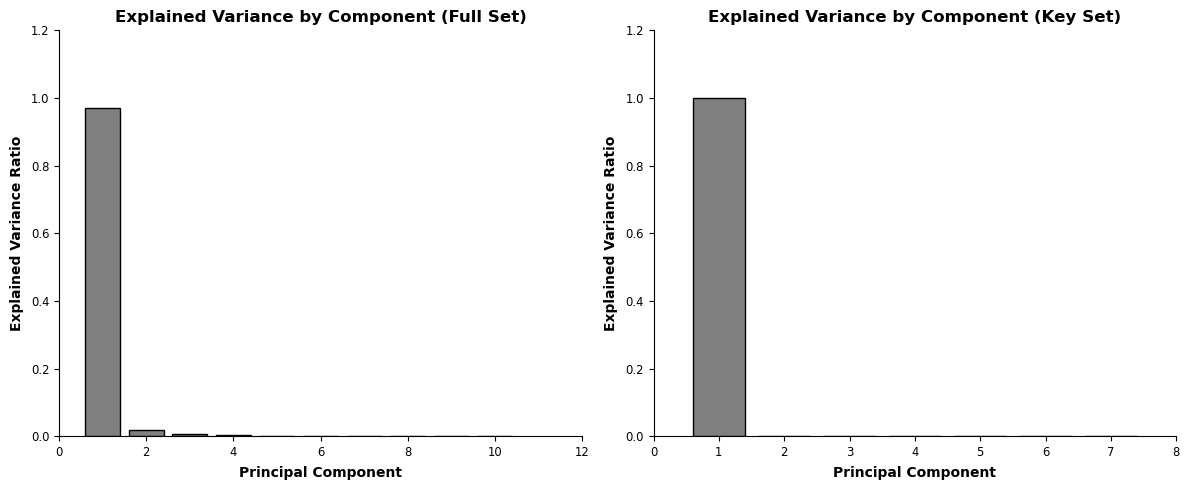

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# APA style if applicable
plt.style.use("apa.mplstyle")

# PCA for plotting (force more components to see distribution)
pca_all_plot = PCA(n_components=min(10, X_all_pca_ready.shape[1]))
pca_key_plot = PCA(n_components=min(10, X_key_pca_ready.shape[1]))

pca_all_plot.fit(X_all_pca_ready)
pca_key_plot.fit(X_key_pca_ready)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Full feature set
ax[0].bar(range(1, len(pca_all_plot.explained_variance_ratio_) + 1),
          pca_all_plot.explained_variance_ratio_,
          color="gray", edgecolor="black")
ax[0].set_title("Explained Variance by Component (Full Set)")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Explained Variance Ratio")

# Key feature set
ax[1].bar(range(1, len(pca_key_plot.explained_variance_ratio_) + 1),
          pca_key_plot.explained_variance_ratio_,
          color="gray", edgecolor="black")
ax[1].set_title("Explained Variance by Component (Key Set)")
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Explained Variance Ratio")

plt.tight_layout()
plt.savefig("Figures/Working/pca_explained_variance_comparison.png", dpi=300)
plt.show()


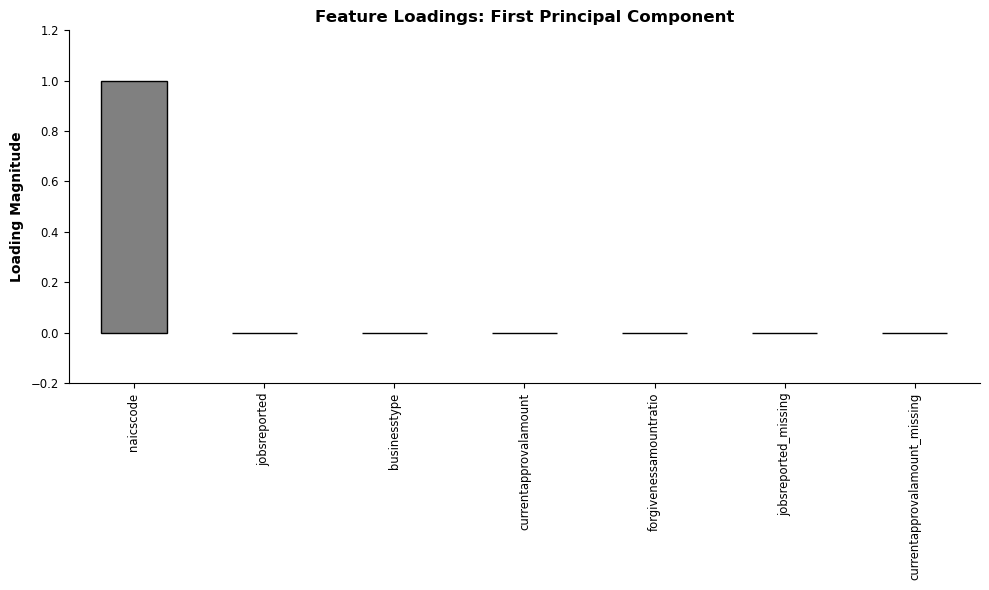

In [18]:
loadings = pd.Series(pca_key.components_[0], index=X_key_pca_ready.columns)

# Plot top contributors to the first principal component
plt.style.use("apa.mplstyle")  # If you're using a custom APA style
plt.figure(figsize=(10, 6))
loadings.sort_values(key=abs, ascending=False).plot(kind="bar", color="gray", edgecolor="black")
plt.title("Feature Loadings: First Principal Component")
plt.ylabel("Loading Magnitude")
plt.tight_layout()
plt.show()


C:\Users\sappw\AppData\Local\Temp\ipykernel_17776\4170724665.py:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


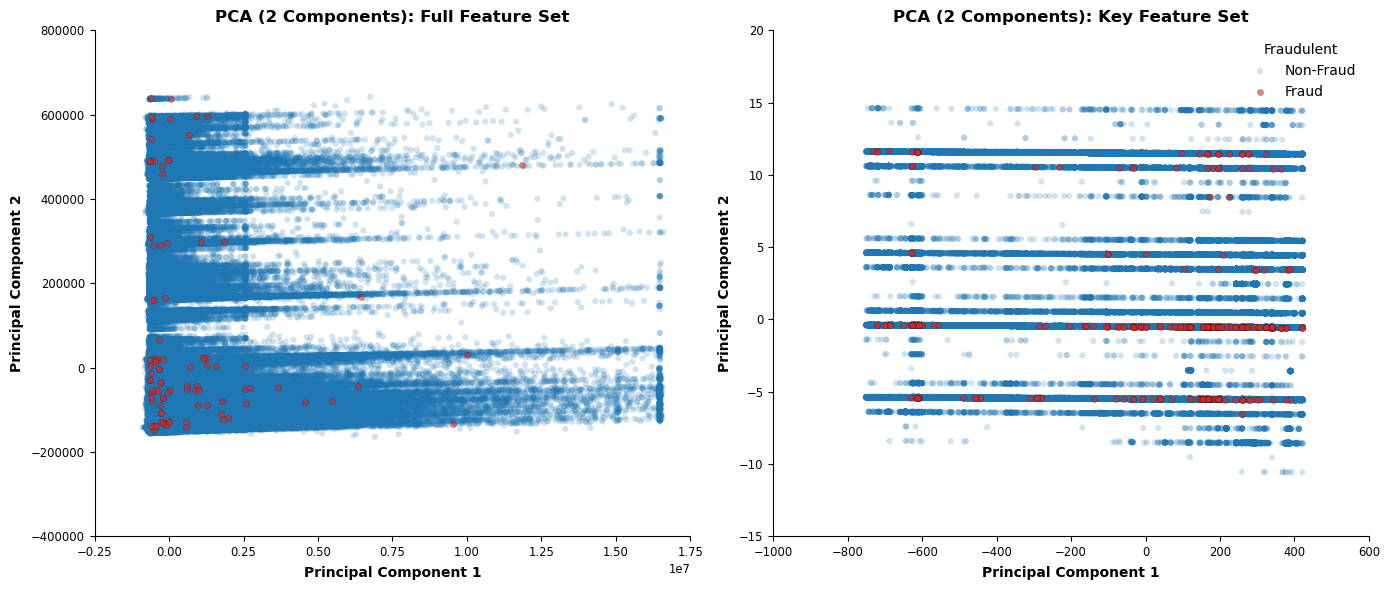

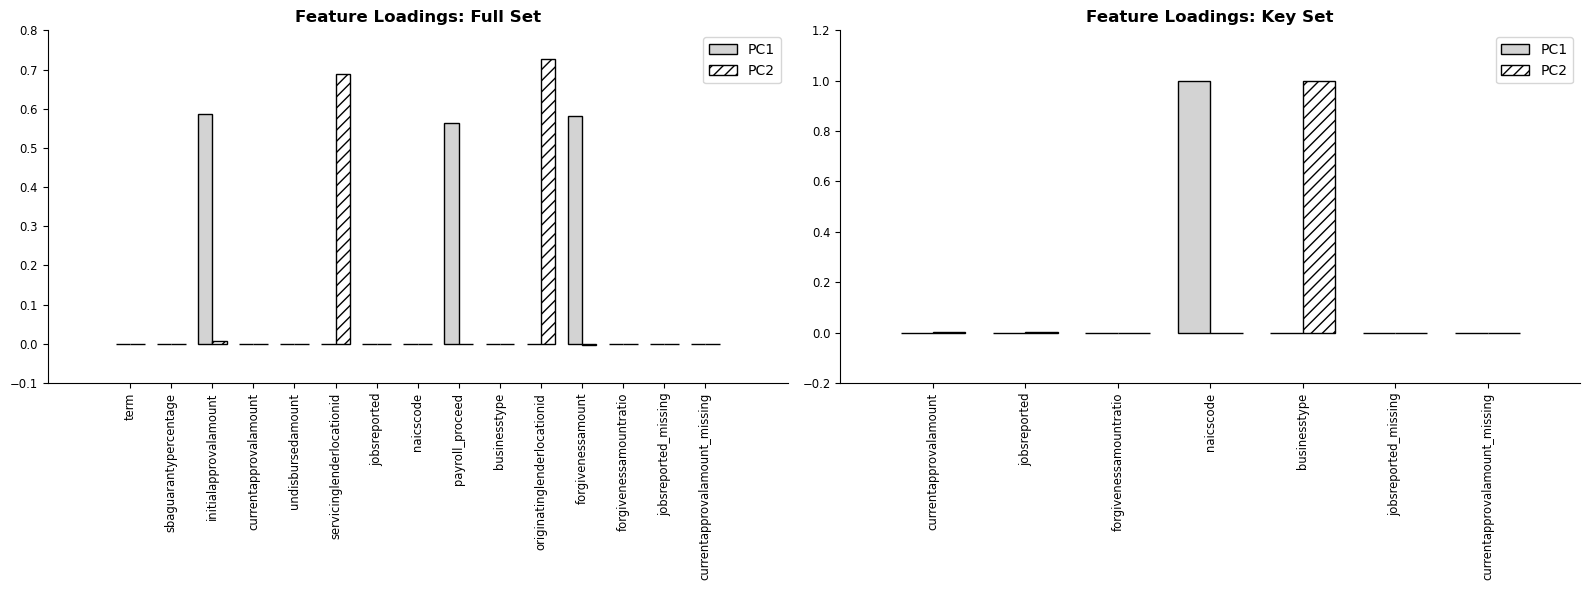

In [27]:
# --- PCA with 2 Components ---
pca_2_all = PCA(n_components=2, random_state=42)
X_all_pca_2 = pca_2_all.fit_transform(X_all_pca_ready)

pca_2_key = PCA(n_components=2, random_state=42)
X_key_pca_2 = pca_2_key.fit_transform(X_key_pca_ready)

# --- 1. Side-by-side PCA scatterplots ---
# Updated color palette for better contrast
colors = {0: "tab:blue", 1: "tab:red"}

# Create side-by-side scatterplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# --- Full Feature Set ---
for fraud_label in sorted(y.loc[X_all_pca_ready.index].unique()):
    idx = y.loc[X_all_pca_ready.index] == fraud_label
    axs[0].scatter(
        X_all_pca_2[idx, 0], X_all_pca_2[idx, 1],
        label="Fraud" if fraud_label else "Non-Fraud",
        c=colors[fraud_label],
        alpha=0.6 if fraud_label else 0.2,
        s=20,
        edgecolor='black' if fraud_label else 'none',
        linewidths=0.2
    )
axs[0].set_title("PCA (2 Components): Full Feature Set")
axs[0].set_xlabel("Principal Component 1")
axs[0].set_ylabel("Principal Component 2")

# --- Key Feature Set ---
for fraud_label in sorted(y.loc[X_key_pca_ready.index].unique()):
    idx = y.loc[X_key_pca_ready.index] == fraud_label
    axs[1].scatter(
        X_key_pca_2[idx, 0], X_key_pca_2[idx, 1],
        label="Fraud" if fraud_label else "Non-Fraud",
        c=colors[fraud_label],
        alpha=0.6 if fraud_label else 0.2,
        s=20,
        edgecolor='black' if fraud_label else 'none',
        linewidths=0.2
    )
axs[1].set_title("PCA (2 Components): Key Feature Set")
axs[1].set_xlabel("Principal Component 1")
axs[1].set_ylabel("Principal Component 2")

# Add legend to right subplot only
axs[1].legend(title="Fraudulent", frameon=False)

# Final formatting
for ax in axs:
    ax.grid(False)

plt.tight_layout()
plt.savefig("Figures/Working/pca_2d_comparison_apa_color.png", dpi=300, bbox_inches="tight")
plt.show()

# --- 2. APA Loadings Plots ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Full set loadings
loadings_all = pca_2_all.components_.T
features_all = X_all_pca_ready.columns
x_all = np.arange(len(features_all))
axs[0].bar(x_all - 0.175, loadings_all[:, 0], width=0.35, label="PC1", color="lightgray", edgecolor="black")
axs[0].bar(x_all + 0.175, loadings_all[:, 1], width=0.35, label="PC2", color="white", edgecolor="black", hatch="///")
axs[0].set_xticks(x_all)
axs[0].set_xticklabels(features_all, rotation=90)
axs[0].set_title("Feature Loadings: Full Set")
axs[0].legend()

# Key set loadings
loadings_key = pca_2_key.components_.T
features_key = X_key_pca_ready.columns
x_key = np.arange(len(features_key))
axs[1].bar(x_key - 0.175, loadings_key[:, 0], width=0.35, label="PC1", color="lightgray", edgecolor="black")
axs[1].bar(x_key + 0.175, loadings_key[:, 1], width=0.35, label="PC2", color="white", edgecolor="black", hatch="///")
axs[1].set_xticks(x_key)
axs[1].set_xticklabels(features_key, rotation=90)
axs[1].set_title("Feature Loadings: Key Set")
axs[1].legend()

plt.tight_layout()
plt.savefig("Figures/Working/pca_2d_loadings_comparison_apa.png", dpi=300, bbox_inches="tight")
plt.show()


C:\Users\sappw\AppData\Local\Temp\ipykernel_17776\1673678129.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


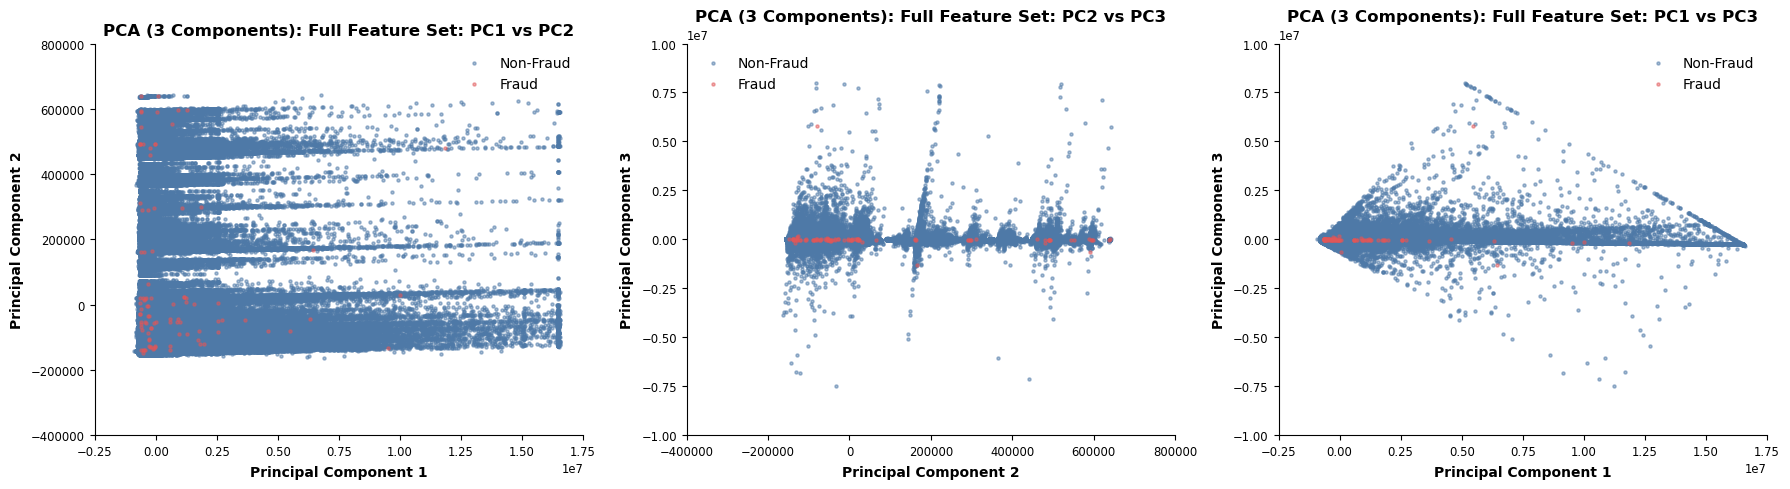

C:\Users\sappw\AppData\Local\Temp\ipykernel_17776\1673678129.py:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\sappw\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


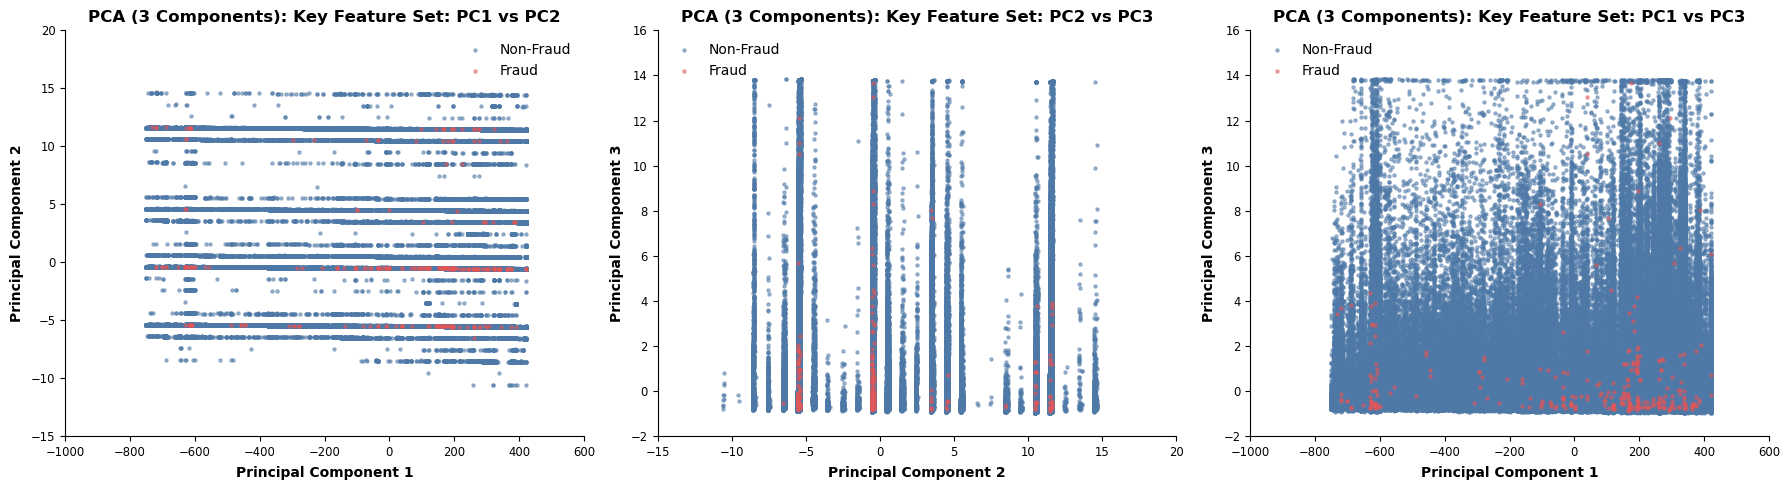

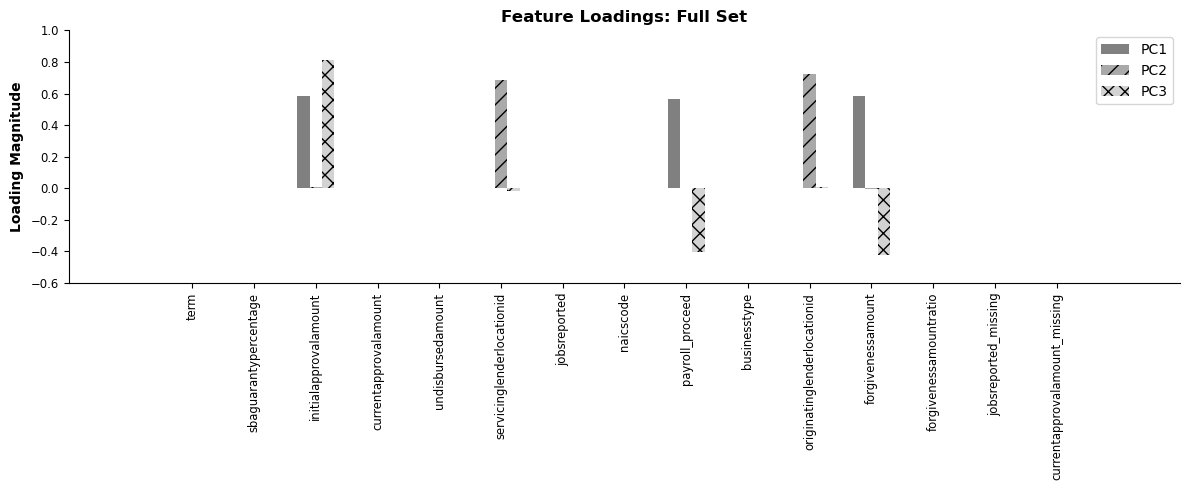

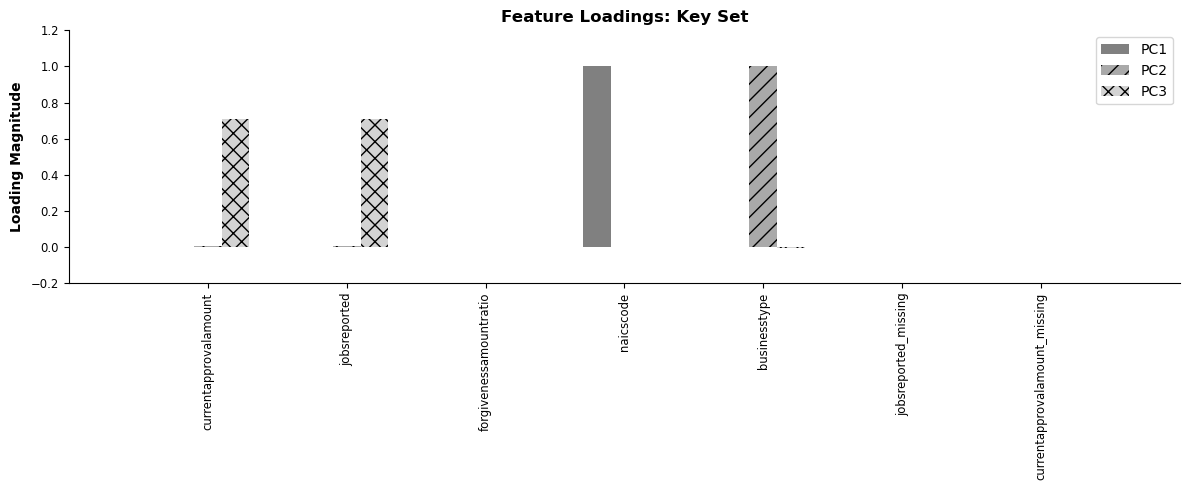

In [29]:
# Run PCA with 3 components
pca_all_3 = PCA(n_components=3, random_state=42)
X_all_3 = pca_all_3.fit_transform(X_all_pca_ready)

pca_key_3 = PCA(n_components=3, random_state=42)
X_key_3 = pca_key_3.fit_transform(X_key_pca_ready)

# Define APA-style fraud label colors
colors = {0: "#4E79A7", 1: "#E15759"}

# Function to make scatter plots for PCA projections with fraud labels
def plot_pca_scatter(X_pca, y_labels, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.style.use("apa.mplstyle")

    for label in sorted(y_labels.unique()):
        mask = y_labels == label
        label_name = "Fraud" if label else "Non-Fraud"
        color = colors[label]

        axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], s=5, alpha=0.5, label=label_name, color=color)
        axes[1].scatter(X_pca[mask, 1], X_pca[mask, 2], s=5, alpha=0.5, label=label_name, color=color)
        axes[2].scatter(X_pca[mask, 0], X_pca[mask, 2], s=5, alpha=0.5, label=label_name, color=color)

    axes[0].set_title(f"{title_prefix}: PC1 vs PC2")
    axes[0].set_xlabel("Principal Component 1")
    axes[0].set_ylabel("Principal Component 2")

    axes[1].set_title(f"{title_prefix}: PC2 vs PC3")
    axes[1].set_xlabel("Principal Component 2")
    axes[1].set_ylabel("Principal Component 3")

    axes[2].set_title(f"{title_prefix}: PC1 vs PC3")
    axes[2].set_xlabel("Principal Component 1")
    axes[2].set_ylabel("Principal Component 3")

    for ax in axes:
        ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

#usage:
plot_pca_scatter(X_all_3, y.loc[X_all_pca_ready.index], "PCA (3 Components): Full Feature Set")
plot_pca_scatter(X_key_3, y.loc[X_key_pca_ready.index], "PCA (3 Components): Key Feature Set")

# Function to plot feature loadings
def plot_loadings(pca, feature_names, title_prefix):
    components = pca.components_
    fig, ax = plt.subplots(figsize=(12, 5))
    bar_width = 0.2
    indices = np.arange(len(feature_names))

    ax.bar(indices - bar_width, components[0], bar_width, label="PC1", color="gray")
    ax.bar(indices, components[1], bar_width, label="PC2", color="darkgray", hatch="//")
    ax.bar(indices + bar_width, components[2], bar_width, label="PC3", color="lightgray", hatch="xx")

    ax.set_title(f"Feature Loadings: {title_prefix}")
    ax.set_xticks(indices)
    ax.set_xticklabels(feature_names, rotation=90)
    ax.set_ylabel("Loading Magnitude")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Plot loadings
plot_loadings(pca_all_3, X_all_pca_ready.columns, "Full Set")
plot_loadings(pca_key_3, X_key_pca_ready.columns, "Key Set")


Figure 4.1
Variance retained by principal components using PCA for the full feature set and key feature subset. The full set required two components to retain 95% of variance, while the key subset required only one.

Figure 4.2
Feature loadings for the PCA run retaining 95% of variance. Left: Full feature set. Right: Key feature subset. Loadings indicate the contribution of each feature to the first two principal components.

Figure 4.3
Two-dimensional PCA scatterplots by fraud label. Left: Full feature set. Right: Key feature subset. Minimal separability is observed, though the key subset shows slightly more compact groupings.

Figure 4.4
Bar plots of feature loadings on the first two principal components from the 2-component PCA. Financial features dominate the full set, while NAICS code and business type are most influential in the key subset.

Figure 4.5
PCA (3-component) projections of the full feature set. Scatterplots display PC1 vs. PC2, PC2 vs. PC3, and PC1 vs. PC3. Colors indicate fraud labels.

Figure 4.6
PCA (3-component) projections of the key feature subset. Scatterplots display PC1 vs. PC2, PC2 vs. PC3, and PC1 vs. PC3. Slightly more cohesive groupings are observed compared to the full set.

Figure 4.7
Feature loadings for the first three principal components in the full feature set. PCA components reflect a balanced contribution from financial and categorical features.

Figure 4.8
Feature loadings for the first three principal components in the key feature subset. NAICS code and business type continue to be dominant contributors.